# Проектная работа

по курсу "Теория вероятностей и математическая статистика".

## Описание

Задача: сравнить доходность от "наивной" торговой стратегии на бирже со случайным инвестированием.
В качестве наивной стратегии возьмем популярную идею о том, что можно успешно торговать, пользуясь двумя индикаторами: скользящим средним за 200 дней и скользящим средним за 10 дней (SMA-200 и SMA-10).
Поскольку в качестве инструментария не используется ничего, кроме стандартных пакетов Python типа pandas, стратегия упрощена до следующих правил:
- короткие позиции не используются
- интервал - день
- используется только цена закрытия
- когда цена ниже SMA-200, алгоритм ничего не делает
- когда цена выше SMA-200, ждем снижения цены ниже SMA-10, и в случае снижения и последующего отскока выше SMA-10 открываем длинную позицию
- ставим stop loss на небольшой убыток -0.3%
- ставим лимит на прибыль 7% (если он достигнут - продаем)
- покупается максимум акций, сколько можно купить на 1 млн. рублей, продаются все купленные ранее акции

В качестве инструментов взяты акции первого уровня, котирующиеся на Московской бирже (это наша выборка).
Стратегия проверяется на исторических ценах для каждой акции отдельно, получившаяся прибыль - это значение переменной.

Рассмотренная система отражает работу "сферического инвестора в вакууме": не учитываются комиссии, размеры лотов, и т.п.

Рандомные торги проводятся следующим образом:
- выбирается день недели, например, вторник
- на 1 млн. рублей покупаются акции по цене закрытия выбранного дня
- в соответствующий день на следующей неделе все акции продаются по цене закрытия
- через неделю цикл повторяется
- если на какой-то неделе торгов в этот день нет, ничего не делаем

Все стратегии работают с 1 марта 2017 года по конец 2020-го.

Скрипты подготовки данных:
- `prep.py` готовит dataframe из csv-файлов, скачанных с Финама
- `trade.py` готовит dataframe с данными продажи и покупки акций по Стратегии (когда, что, сколько, почем)
- `randomtrade.py` аналогично для рандомных продаж (только берется несколько дней, соответственно, несколько выборок в одном dataframe)

Примечание: подобные наивные алгоритмы очень неустойчивы и чувствительны к параметрам, стоит на доли процента поменять уровень лимита, например, и вместо прибыли получим убыток. Поэтому рассматривать все расчеты можно исключительно в качестве технического упражнения.

## Исходные данные

In [3]:
import pickle
import pandas as pd

In [4]:
with open('trade.pkl', 'rb') as file:
    trade_df = pickle.load(file)
trade_df.sample(3)

,Date,Ticker,NSec,Price
33,2020-01-31,RTKM,-11312,88.0000
2,2020-02-13,MGNT,266,3750.0000
8,2017-05-11,HYDR,1085069,0.9216


In [5]:
with open('random.pkl', 'rb') as file:
    random_df = pickle.load(file)
random_df.sample(3)

,Date,RDay,Ticker,NSec,Price
72,2018-07-26,3,HYDR,1476450,0.6773
29,2018-06-29,4,DSKY,-10804,92.0000
109,2019-05-14,1,ENRU,-923787,1.0925


## Подготовка данных

In [7]:
def get_profits(df):
    return (
        df
        .assign(Profit = lambda x: -x.NSec * x.Price)
        .groupby('Ticker')
        .agg({'Profit' : 'sum'})
)

In [8]:
random_result = random_df.groupby('RDay').apply(get_profits).unstack(0)
random_result.columns = list(map(lambda x: f"Random{x[1]}", random_result.columns))
result_df = random_result.join(get_profits(trade_df).rename(columns={'Profit': 'Strategy'}))
result_df.sample(3)

,Random0,Random1,Random2,Random3,Random4,Strategy
Ticker,,,,,,
SFIN,-136816.900,151360.600,-576301.000,-290848.000,-94668.500,-215014.100
UPRO,-3562.113,-427124.611,64880.746,-98375.402,-233269.347,-127030.714
AFLT,-295900.670,-673203.150,-995347.960,-634306.480,-494554.390,86539.670


## Анализ

### Финансовые результаты

Все стратегии позволили получить прибыль, за исключением рандомных торгов по ценам закрытия среды (день №2 - это среда, так как нумерация с нуля). Что за беда именно со средой, не очень понятно. Будем считать, что это нехарактерная аномалия.

In [16]:
result_df.agg('sum').astype(int).sort_values(ascending=False)

Random1     4554014
Random4     3536337
Random0     3190789
Strategy    1059879
Random3      570741
Random2    -4363349
dtype: int32

Разные акции показали разные результаты, от положительных до отрицательных. Разброс большой.

In [17]:
result_df.describe()

,Random0,Random1,Random2,Random3,Random4,Strategy
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,83968.133894,119842.490544,-114824.979433,15019.505372,93061.522835,27891.575126
std,303116.955916,323050.627590,360096.129102,344194.799547,307099.258872,201315.081952
min,-416523.635000,-673203.150000,-995347.960000,-730548.000000,-625484.176871,-361476.007500
25%,-112290.593579,-30771.742500,-383864.025000,-258704.049918,-83340.589800,-135063.841000
50%,30535.530000,152542.270000,-88166.722500,60934.880000,71066.534650,18923.155450
75%,276984.457500,331336.520750,67414.751500,204759.259950,316675.900000,136092.205325
max,858369.130000,642565.500000,632431.010000,847477.010000,705933.135000,498222.000000


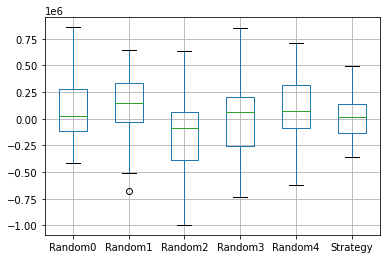

In [18]:
result_df.boxplot();

### ANOVA

In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Логичная гипотеза $H_0$ в данном случае - нет никаких различий между средними во всех группах, и применять мега-стратегию из серии "делай так и разбогатеешь" ничуть не прибыльнее, чем торговать безумным рандомным способом.

Однако присутствие аномальной группы Random2 внезапно позволяет показать статистически значимые различия.

In [21]:
trade_lm = ols('value ~ C(variable)', data=result_df.melt()).fit()
sm.stats.anova_lm(trade_lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(variable),5.0,1.361435e+12,2.722871e+11,2.820563,0.017176
Residual,222.0,2.143109e+13,9.653643e+10,NaN,NaN


А вот если эту группу не учитывать и считать, что "там что-то с данными", то результат весьма показательный.

In [22]:
df = result_df.melt().query('variable != "Random2"')
trade_lm = ols('value ~ C(variable)', data=df).fit()
sm.stats.anova_lm(trade_lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(variable),4.0,3.034799e+11,7.586999e+10,0.843845,0.499019
Residual,185.0,1.663333e+13,8.990987e+10,NaN,NaN


## Вывод

Основной вывод: "наивными" торговыми стратегиями лучше не пользоваться. 

P.S. К сожалению, ситуация с занятостью не позволяет заняться доработкой этого упражнения до реального "курсового".